# GRID3 Nigeria Road Network Analysis




The CIESIN GRID3 data provides high-resolution geospatial data that can be used to analyze various aspects of infrastructure and services in Nigeria. One practical application of this data is to find optimal routes between schools and health facilities. Below is an example of how to achieve this using Python and relevant libraries.

<a target="_blank" href="https://colab.research.google.com/github/ciesin/GRID3_dataUserGuide/blob/master/notebooks/api_nga_network.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
# install neccessary packages
# !pip install osmnx
# !pip install mapclassify
# !pip install folium
# !pip install momepy

In [52]:
# import
import geopandas as gpd
import networkx as nx
import momepy
import osmnx as ox
import matplotlib.pyplot as plt
from itertools import product
import numpy as np
import mapclassify
import folium
import json
import pandas as pd
import momepy 
import requests 
import random
import matplotlib.colors as mcolors


In [ ]:
# install arcgis API for accessing data
# check that arcgis is installed 
# !pip install arcgis
    

In [4]:
# import arcgis
from arcgis.gis import GIS 


In [5]:
# Anonymously authenticate arcgis API
gis = GIS()

In [6]:
def fetch_nga_roads(bbox, crs, record_limit, url):
    """
    Fetch NGA roads from an ArcGIS FeatureServer within a bounding box.

    Parameters
    ----------
    bbox : dict
        Bounding box with keys xmin, ymin, xmax, ymax (in EPSG:3857).
    crs : str, optional
        CRS for the output GeoDataFrame (default: EPSG:3857).
    record_limit : int, optional
        Maximum number of records per request (default: 200000).
    url : str, optional
        ArcGIS FeatureServer query URL.

    Returns
    -------
    geopandas.GeoDataFrame
        GeoDataFrame containing all fetched road features.
    """

    params = {
        "f": "geojson",
        "where": "1=1",
        "geometry": json.dumps({
            **bbox,
            "spatialReference": {"wkid": int(crs.split(":")[1])},
        }),
        "geometryType": "esriGeometryEnvelope",
        "spatialRel": "esriSpatialRelContains",
        "outFields": "*",
        "returnGeometry": "true",
        "resultRecordCount": record_limit,
    }

    all_features = []
    offset = 0

    while True:
        paged_params = params | {"resultOffset": offset}
        r = requests.get(url, params=paged_params)
        r.raise_for_status()

        data = r.json()
        features = data.get("features", [])

        if not features:
            break

        all_features.extend(features)
        offset += len(features)
        
    valid_features = [
        f for f in all_features
        if f.get("geometry") is not None]

    return gpd.GeoDataFrame.from_features(valid_features, crs=crs)

In [7]:
# Read in service for NGA roads
url = "https://services3.arcgis.com/BU6Aadhn6tbBEdyk/arcgis/rest/services/GRID3_NGA_roads/FeatureServer/0/query"

boundbox =  {
        "xmin": 360102.4944,
        "ymin": 725614.4996,
        "xmax": 381199.1042,
        "ymax": 746837.3928  }



gdf = fetch_nga_roads(boundbox, crs="EPSG:3857", record_limit=1000, url=url)

gdf.head()

,geometry,OBJECTID,id,country,iso3,source_id,class,speed_estimate,speed_estimate_method,road_surface,names,subclass,speed_limits,date,source_acronym,Shape__Length
0,"LINESTRING (3.353 6.561, 3.352 6.564, 3.351 6....",375,0825887fffffffff047f4f4e7c46bb8d,Nigeria,NGA,Overture / OSM,unclassified,40,literature review,,,,,2025,OVERTURE_OSM_001,660.977176
1,"LINESTRING (3.394 6.653, 3.395 6.653, 3.396 6....",2121,0835882fffffffff046f5d76209c94af,Nigeria,NGA,Overture / OSM,motorway,80,GPS,paved,Lagos-Ibadan Expressway,,,2025,OVERTURE_OSM_001,4708.736787
2,"LINESTRING (3.375 6.664, 3.375 6.665)",2129,0835882fffffffff046ffcc2abaf4fde,Nigeria,NGA,Overture / OSM,residential,20,literature review,unpaved,,,,2025,OVERTURE_OSM_001,65.118153
3,"LINESTRING (3.39 6.68, 3.39 6.68, 3.39 6.679, ...",2130,0835882fffffffff046fff468b9d4a49,Nigeria,NGA,Overture / OSM,track,10,literature review,unpaved,,,,2025,OVERTURE_OSM_001,1929.374551
4,"LINESTRING (3.414 6.689, 3.413 6.688, 3.413 6....",2152,0835882fffffffff047f5f6082b04656,Nigeria,NGA,Overture / OSM,motorway,80,GPS,paved,Lagos-Ibadan Expressway,,,2025,OVERTURE_OSM_001,4815.947415


<Axes: >

<Figure size 720x480 with 0 Axes>

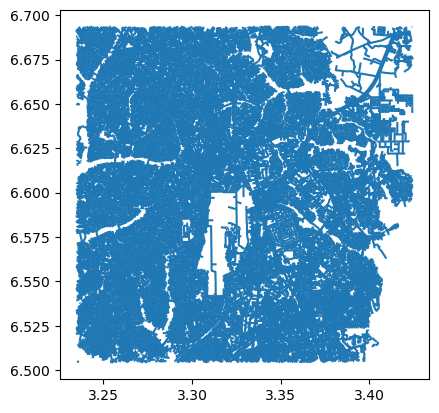

In [9]:
# Plot roads
# size 
plt.figure(figsize=(6, 4), dpi=120)
gdf.plot()

In [10]:
exploded_road_gdf = gdf.copy()

exploded_road_gdf = exploded_road_gdf.set_crs(epsg=4326, allow_override=True)
    
exploded_road_gdf = exploded_road_gdf.to_crs('EPSG:3857')

exploded_road_gdf = exploded_road_gdf.explode(index_parts=True) 


exploded_road_gdf['length_meters'] = exploded_road_gdf.geometry.length 

# Build network
Gs = momepy.gdf_to_nx(
    exploded_road_gdf,
    directed='MultiDiGraph',           
    approach='primal',
    integer_labels=True,
    preserve_index=True,
    length='length_meters'        
)


# 🔧 OSMnx compatibility: alias length_meters → length
for _, _, data in Gs.edges(data=True):
    data["length"] = data["length_meters"] 




# # Back to GeoDataFrames
nodes, edges = momepy.nx_to_gdf(Gs, points=True, lines=True)
 

# # Try roundabout simplification
edges = momepy.roundabout_simplification(edges)
 
 
edges.head()

C:\Users\jfm2205\AppData\Local\Temp\16\ipykernel_16616\500756028.py:35: FutureWarning: `roundabout_simplification` is deprecated and will be removed in momepy 1.0. The functionality has been superseded by the `neatnet` package.  See https://uscuni.org/neatnet for details.
  edges = momepy.roundabout_simplification(edges)
c:\Users\jfm2205\AppData\Local\ESRI\conda\envs\jfm-py2\Lib\site-packages\momepy\preprocessing.py:797: FutureWarning: Class based API like `momepy.CircularCompactness` is deprecated. Replace it with `momepy.circular_compactness` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  circom_serie = CircularCompactness(gdf, area_col).series


,OBJECTID,id,country,iso3,source_id,class,speed_estimate,speed_estimate_method,road_surface,names,...,speed_limits,date,source_acronym,Shape__Length,geometry,length_meters,length,node_start,node_end,simplification_group
"(0, 0)",375,0825887fffffffff047f4f4e7c46bb8d,Nigeria,NGA,Overture / OSM,unclassified,40,literature review,,,...,,2025,OVERTURE_OSM_001,660.977176,"LINESTRING (373284.209 731941.259, 373142.699 ...",660.977176,660.977176,0,1,<NA>
"(1, 0)",2121,0835882fffffffff046f5d76209c94af,Nigeria,NGA,Overture / OSM,motorway,80,GPS,paved,Lagos-Ibadan Expressway,...,,2025,OVERTURE_OSM_001,4708.736787,"LINESTRING (377835.061 742222.484, 377903.879 ...",4708.736787,4708.736787,2,3,<NA>
"(2, 0)",2129,0835882fffffffff046ffcc2abaf4fde,Nigeria,NGA,Overture / OSM,residential,20,literature review,unpaved,,...,,2025,OVERTURE_OSM_001,65.118153,"LINESTRING (375667.815 743564.588, 375679.303 ...",65.118153,65.118153,4,5,<NA>
"(3, 0)",2130,0835882fffffffff046fff468b9d4a49,Nigeria,NGA,Overture / OSM,track,10,literature review,unpaved,,...,,2025,OVERTURE_OSM_001,1929.374551,"LINESTRING (377331.652 745306.289, 377349.007 ...",1929.374551,1929.374551,6,7,<NA>
"(4, 0)",2152,0835882fffffffff047f5f6082b04656,Nigeria,NGA,Overture / OSM,motorway,80,GPS,paved,Lagos-Ibadan Expressway,...,,2025,OVERTURE_OSM_001,4815.947415,"LINESTRING (380005.724 746285.084, 379966.54 7...",4815.947415,4815.947415,8,9,<NA>


In [12]:

# check simplification group
edges['simplification_group'].value_counts()
 

simplification_group
60    16
84    16
39    16
47    14
81    14
      ..
21     2
57     2
63     2
23     2
31     2
Name: count, Length: 98, dtype: Int64

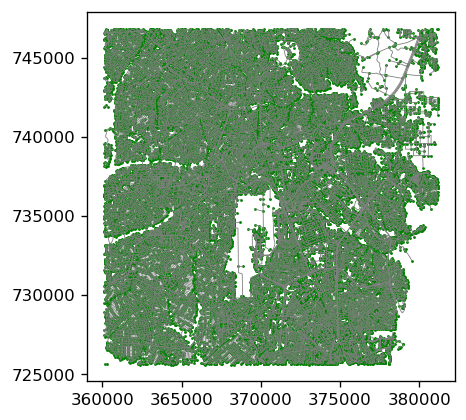

In [18]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=120)

edges.plot(ax=ax, color="gray", lw=0.5)
nodes.plot(ax=ax, color="green", markersize=0.5)

plt.show()

In [19]:
# Calculate time to traverse a road segment in minutes using the speed estimate and length
edges["travel_time_mins"] = ((edges["length_meters"]/1000) / (edges["speed_estimate"])) * 60

# drop if travel_time_mins is infinite or NaN or less than equal to zero
edges = edges.replace([np.inf, -np.inf], np.nan)
edges = edges.dropna(subset=['travel_time_mins'])
edges = edges[edges['travel_time_mins'] > 0]    

edges.head()

,OBJECTID,id,country,iso3,source_id,class,speed_estimate,speed_estimate_method,road_surface,names,...,date,source_acronym,Shape__Length,geometry,length_meters,length,node_start,node_end,simplification_group,travel_time_mins
"(0, 0)",375,0825887fffffffff047f4f4e7c46bb8d,Nigeria,NGA,Overture / OSM,unclassified,40,literature review,,,...,2025,OVERTURE_OSM_001,660.977176,"LINESTRING (373284.209 731941.259, 373142.699 ...",660.977176,660.977176,0,1,<NA>,0.991466
"(1, 0)",2121,0835882fffffffff046f5d76209c94af,Nigeria,NGA,Overture / OSM,motorway,80,GPS,paved,Lagos-Ibadan Expressway,...,2025,OVERTURE_OSM_001,4708.736787,"LINESTRING (377835.061 742222.484, 377903.879 ...",4708.736787,4708.736787,2,3,<NA>,3.531553
"(2, 0)",2129,0835882fffffffff046ffcc2abaf4fde,Nigeria,NGA,Overture / OSM,residential,20,literature review,unpaved,,...,2025,OVERTURE_OSM_001,65.118153,"LINESTRING (375667.815 743564.588, 375679.303 ...",65.118153,65.118153,4,5,<NA>,0.195354
"(3, 0)",2130,0835882fffffffff046fff468b9d4a49,Nigeria,NGA,Overture / OSM,track,10,literature review,unpaved,,...,2025,OVERTURE_OSM_001,1929.374551,"LINESTRING (377331.652 745306.289, 377349.007 ...",1929.374551,1929.374551,6,7,<NA>,11.576247
"(4, 0)",2152,0835882fffffffff047f5f6082b04656,Nigeria,NGA,Overture / OSM,motorway,80,GPS,paved,Lagos-Ibadan Expressway,...,2025,OVERTURE_OSM_001,4815.947415,"LINESTRING (380005.724 746285.084, 379966.54 7...",4815.947415,4815.947415,8,9,<NA>,3.611961


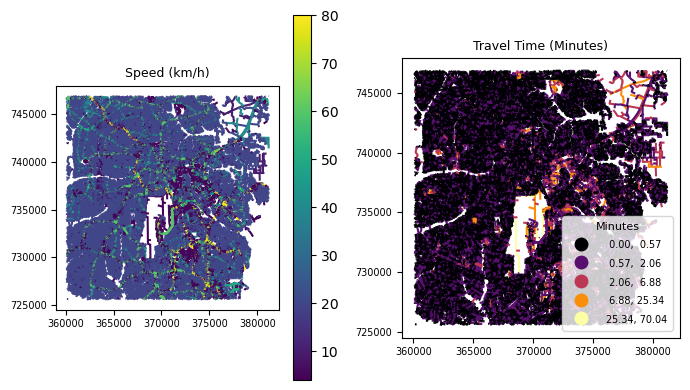

In [42]:

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(7, 4), dpi=100)

# --- Plot speed estimate ---
edges.plot(
    column="speed_estimate",
    legend=True,
    ax=ax1,
    cmap="viridis",
)
ax1.set_title("Speed (km/h)", fontsize=9)
ax1.tick_params(labelsize=7)

leg1 = ax1.get_legend()
if leg1:
    leg1.set_loc("lower left")
    leg1.set_title("Speed (km/h)", prop={"size": 8})
    for txt in leg1.get_texts():
        txt.set_fontsize(7)

# --- Plot travel time ---
edges.plot(
    column="travel_time_mins",
    legend=True,
    ax=ax2,
    cmap="inferno",
    scheme="natural_breaks",
)
ax2.set_title("Travel Time (Minutes)", fontsize=9)
ax2.tick_params(labelsize=7)

leg2 = ax2.get_legend()
if leg2:
    leg2.set_loc("lower right")
    leg2.set_title("Minutes", prop={"size": 8})
    for txt in leg2.get_texts():
        txt.set_fontsize(7)

plt.tight_layout()
plt.show()

In [43]:
from pyproj import Transformer

# Geocode an origin and destination address
# Origin
orig_address = "Oshitelu St, Lagos, Nigeria"

orig_y, orig_x = ox.geocode(orig_address)  # notice the coordinate order (y, x)!

# Destination
dest_address = "Obafemi Awolowo Wy, Lagos, Nigeria"
dest_y, dest_x = ox.geocode(dest_address) 


# Transformer: lon/lat → graph CRS
transformer = Transformer.from_crs(
    "EPSG:4326",
    Gs.graph["crs"],
    always_xy=True
)

# Print coordinates
print("Origin coords:", orig_x, orig_y)
print("Destination coords:", dest_x, dest_y)

orig_x_p, orig_y_p = transformer.transform(orig_x, orig_y)
dest_x_p, dest_y_p = transformer.transform(dest_x, dest_y)

# Snap to graph
orig_node_id, dist_to_orig = ox.distance.nearest_nodes(
    Gs, X=orig_x_p, Y=orig_y_p, return_dist=True
)
dest_node_id, dist_to_dest = ox.distance.nearest_nodes(
    Gs, X=dest_x_p, Y=dest_y_p, return_dist=True
)

# Print distance to nearest node
print("Origin node-id:", orig_node_id, "and distance:", dist_to_orig, "meters.")
print("Destination node-id:", dest_node_id, "and distance:", dist_to_dest, "meters.")




# Calculate shortest path between origin and destionation nodes and the length
path = nx.shortest_path(Gs, source=orig_node_id, target=dest_node_id, weight='travel_time_mins')
length = nx.shortest_path_length(Gs, source=orig_node_id, target=dest_node_id, weight='travel_time_mins')





Origin coords: 3.339861 6.5943937
Destination coords: 3.3511002 6.6082757
Origin node-id: 15790 and distance: 69.41404267339831 meters.
Destination node-id: 30133 and distance: 49.45782604997911 meters.


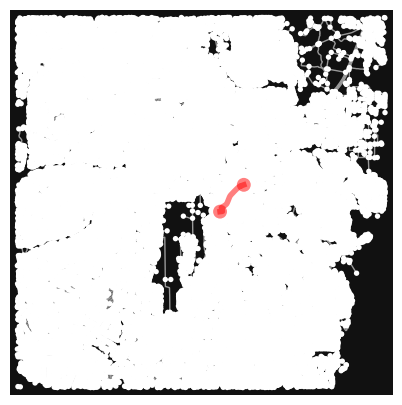

In [44]:
# Shortest path based on distance
fig, ax = ox.plot_graph_route(Gs, path, figsize=(5,5), dpi=120  )

# Add the travel time as title
ax.set_xlabel("Shortest path is {t: .1f} minutes.".format(t=length))

#show plot
plt.show()

In [ ]:
#| execute: false
#| output: false


# Explore graph edges and route together in a single map
route_edges = ox.routing.route_to_gdf(Gs, path, weight='length')

m = edges.explore(color="black", tiles="cartodbdarkmatter")
m = route_edges.explore(m=m, color="maroon", style_kwds={"weight": 5})

# Add the Esri World Imagery tile layer
folium.TileLayer(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri',
    name='Esri Satellite',
    overlay=False,
    control=True
).add_to(m)

# Add a layer control to toggle between tile layers
folium.LayerControl().add_to(m)
m

In [45]:
# Read in Nigeria health facilities layer
layer_url = "https://services3.arcgis.com/BU6Aadhn6tbBEdyk/arcgis/rest/services/GRID3_NGA_health_facilities_v2_0/FeatureServer/0/query"
 

# Create bounding box
query_extent = {
    "xmin": 3.328171,
    "ymin": 6.582383,
    "xmax": 3.383102,
    "ymax": 6.633909}



health_fac = fetch_nga_roads(query_extent, crs="EPSG:4326", record_limit=200000, url=layer_url)

 

health_fac.head(5)

,geometry,OBJECTID,globalid,nhfr_uid,nhfr_facility_code,country,iso,state,lga,lga_name_disagreement,...,facility_name,facility_name_source,ownership,ownership_type,facility_level,facility_level_option,latitude,longitude,geocoordinates_source,last_updated
0,POINT (3.34985 6.59825),151,d34b8933-7c5c-45e6-a59e-f8108b3a8e58,62363642.0,24/11/1/1/2/0020,Nigeria,NGA,Lagos,Ikeja,0,...,Life Health Care Clinic,NHFR_2024,Private,Unknown,Primary,Primary Health Center,6.598250,3.349850,GRID3_EHEALTH,2024-11-11
1,POINT (3.36239 6.58945),589,3854bf39-0017-4008-8095-dd6ac833cbe9,39876675.0,24/11/1/1/1/0022,Nigeria,NGA,Lagos,Ikeja,0,...,Opebi Primary Health Center,NHFR_2024,Public,Unknown,Primary,Primary Health Center,6.589447,3.362393,GRID3_EHEALTH,2024-11-11
2,POINT (3.36413 6.60097),594,3167880d-17be-4b24-ba45-d5a61abe160a,52365838.0,24/11/1/1/1/0018,Nigeria,NGA,Lagos,Ikeja,0,...,Oregun Primary Health Center,NHFR_2024,Public,Unknown,Primary,Primary Health Center,6.600967,3.364128,GRID3_EHEALTH,2024-11-11
3,POINT (3.33843 6.59715),596,4c0b8011-af9c-4d55-bbc4-4f9aa2fbe04a,13500518.0,24/11/1/1/1/0009,Nigeria,NGA,Lagos,Ikeja,0,...,Ikeja Primary Health Center,NHFR_2024,Public,Local Government,Primary,Primary Health Center,6.597150,3.338432,GRID3_EHEALTH,2024-11-11
4,POINT (3.3423 6.63057),670,4eef270b-e351-4cf2-bf60-ff31051dd22b,77159777.0,24/11/1/1/1/0011,Nigeria,NGA,Lagos,Ikeja,0,...,Ogba Primary Health Center,NHFR_2024,Public,Local Government,Primary,Primary Health Center,6.630571,3.342302,GRID3_EHEALTH,2024-11-11


In [46]:
# Read in Nigeria schools layer
layer_url = "https://services3.arcgis.com/BU6Aadhn6tbBEdyk/arcgis/rest/services/Schools_in_Nigeria/FeatureServer/0/query"
# feature_layer = FeatureLayer(layer_url)

# Create bounding box
query_extent = {
    "xmin": 3.328171,
    "ymin": 6.582383,
    "xmax": 3.383102,
    "ymax": 6.633909,
     
}
 
schools = fetch_nga_roads(query_extent, crs="EPSG:4326", record_limit=200000, url=layer_url)

schools.head(5)

,geometry,FID,globalid,uniq_id,timestamp,editor,wardname,wardcode,lganame,lgacode,...,secondary_,student_ct,teacher_ct,poi_type,education,management,subtype,category,name,source
0,POINT (3.34134 6.6304),61,7a4b0b1e-3732-4674-b129-f6048d8a0ec0,842635,1607644800000,najib.adam,Ogba / Oluwole,LASIKA07,Ikeja,25011,...,,,,School,Formal,Public,Standard,Mixed,Ogba Primary and Secondary School,OSGOF
1,POINT (3.33565 6.60116),345,77b5417d-df45-4e3f-b850-8e5eb1762a25,842947,1607644800000,najib.adam,Anifowoshe,LASIKA05,Ikeja,25011,...,,,,School,Formal,Private,Standard,Primary,Olufunmilayo Nursery And Primary School,GRID
2,POINT (3.33294 6.62794),377,b89c364f-d3fa-4c92-9de0-ee1c13cab316,842979,1607644800000,najib.adam,Ijaiye / Ifako,LASIOE10,Ifako/Ijaye,25010,...,,85,6,School,Formal,Private,Standard,Primary,Great Talents Nursery And Primary School,GRID
3,POINT (3.33544 6.62886),2178,a4ce123c-53b2-4a53-9be2-9994cd826e22,844889,1607644800000,najib.adam,Ijaiye / Ifako,LASIOE10,Ifako/Ijaye,25010,...,,80,8,School,Formal,Private,Standard,Primary,Jnissi Nursery And Primary School Lsdpc Estate,GRID
4,POINT (3.35361 6.63257),2200,5e9dd4d0-8bbd-47c2-bc58-3e14bc8cd81d,844910,1607644800000,najib.adam,Ogba / Oluwole,LASIKA07,Ikeja,25011,...,,,,School,Formal,Private,Standard,Primary,Md Nursery And Primary School,GRID


In [50]:
#set same crs as graph
schools = schools.to_crs(Gs.graph["crs"])
health_fac = health_fac.to_crs(Gs.graph["crs"])

schools["longitude"] = schools.geometry.x
schools["latitude"] = schools.geometry.y

health_fac["longitude"] = health_fac.geometry.x
health_fac["latitude"] = health_fac.geometry.y


# Caclulate shortest route between every school and health facility using the travel_time_mins variable as the weight
# this can take a few minutes

weight_attribute = 'travel_time_mins'

# Find nearest nodes to each school and health facility
orig_node_id, dist_to_orig = ox.distance.nearest_nodes(
    Gs, 
    X=schools.geometry.x, Y=schools.geometry.y, return_dist=True)
dest_node_id, dist_to_dest = ox.distance.nearest_nodes(Gs, X=health_fac.geometry.x, Y=health_fac.geometry.y, return_dist=True)

shortest_paths = {}

for source in orig_node_id:
    for target in dest_node_id:
        try:
            # Get the actual path
            path = nx.shortest_path(Gs, source=source, target=target, weight=weight_attribute)
            # Get the path length
            length = nx.shortest_path_length(Gs, source=source, target=target, weight=weight_attribute)
            shortest_paths[(source, target)] = {'path': path, 'length': length}
        except nx.NetworkXNoPath:
          # build dictionary with shortest routes
            shortest_paths[(source, target)] = {'path': None, 'length': float('inf')}
 

print("Unique school nodes:", len(set(orig_node_id)))
print("Unique facility nodes:", len(set(dest_node_id)))
print("Snap distances (schools):", dist_to_orig.min(), dist_to_orig.max())
print("Snap distances (facilities):", dist_to_dest.min(), dist_to_dest.max())



Unique school nodes: 224
Unique facility nodes: 153
Snap distances (schools): 1.0962485485910776 116.9630130515727
Snap distances (facilities): 0.0 118.8161232238598


In [53]:
# create dataframe of shortest paths between every school and health facility and drop school/health facility combinations that aren't the closest
 
# build dataframe
df = pd.DataFrame(shortest_paths).T
df = df.reset_index()
df = df.rename(columns={'level_0': 'school_node', 'level_1': 'health_facility_node'})
df = df.replace([np.inf, -np.inf], np.nan)

# sort by length and keep only the shortest routes for each school
df = df.sort_values(by=['school_node', 'length'], ascending=[True, True])
df = df.drop_duplicates(subset=['school_node'], keep='first')
df.head(5)

C:\Users\jfm2205\AppData\Local\Temp\16\ipykernel_16616\2554942911.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace([np.inf, -np.inf], np.nan)


,school_node,health_facility_node,path,length
33384,83,30027,"[83, 84, 124, 160, 13322, 47675, 42536, 13314,...",18.0
624,116,116,[116],0.0
1057,221,15747,"[221, 222, 3836, 3837, 15788, 15747]",5.0
17962,643,183,"[643, 17917, 5788, 661, 5793, 13140, 183]",6.0
28450,712,712,[712],0.0


In [54]:
# merge nearest node ID back to schools and health facitility geodataframes

# set node ids
schools['node_id'] = orig_node_id
health_fac['node_id'] = dest_node_id

# get only columns needed for merge
school_merge = schools[['node_id', 'name','latitude','longitude']]
health_merge = health_fac[['node_id', 'facility_name']]

# merge nearest routes with school and health facility information
nearest_df = df.merge(school_merge, left_on='school_node', right_on='node_id')
nearest_df = nearest_df.merge(health_merge, left_on='health_facility_node', right_on='node_id')

# drop duplicates
nearest_df1 = nearest_df.drop_duplicates(subset=['school_node', 'length'])
nearest_df1.head()

,school_node,health_facility_node,path,length,node_id_x,name,latitude,longitude,node_id_y,facility_name
0,83,30027,"[83, 84, 124, 160, 13322, 47675, 42536, 13314,...",18.0,83,Prime Achievers Academy,740135.670587,374852.800503,30027,Ikosi Isheri Mutual Health Plan
1,116,116,[116],0.0,116,Md Nursery And Primary School,739988.537463,373322.421393,116,The Brighthope Hospital Specialist
2,221,15747,"[221, 222, 3836, 3837, 15788, 15747]",5.0,221,Anifowoshe Primary School Ikeja,736429.645181,371129.163511,15747,God'S Love Hospital
3,643,183,"[643, 17917, 5788, 661, 5793, 13140, 183]",6.0,643,Eden Montessori School,739945.318972,374112.520483,183,Amazing Grace Medical Center
5,712,712,[712],0.0,712,Stepping Stone Montessori,736576.783257,373368.577763,712,Ageless Physio Clinic


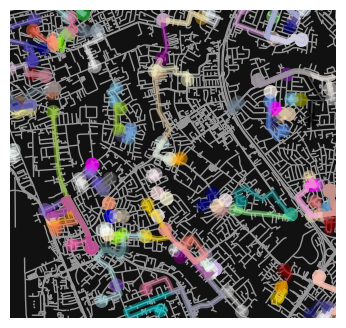

In [55]:
# visualize all nearest routes

# drop routes with nans
nearest_df1 = nearest_df1.dropna(subset=['path'])

# convert to list
routes = nearest_df1['path'].tolist()

# set route colors
num_paths = len(routes)
color_pool = list(mcolors.CSS4_COLORS.values()) # 148+ colors
path_colors = random.choices(color_pool, k=num_paths)

# plot map

transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)

xmin, ymin = transformer.transform(3.328171, 6.582383)
xmax, ymax = transformer.transform(3.383102, 6.633909)

bbox_3857 = (xmin, ymin, xmax, ymax)
    
fig, ax = ox.plot_graph_routes(Gs, routes,route_colors=path_colors, route_linewidth=6, node_size=0, bbox=bbox_3857, figsize=(6,4), dpi=120)

plt.show()

In [ ]:
#| execute: false
#| output: false



# Explore a route interactively

# select school to view
nearest_df1_s = nearest_df1[nearest_df1['name'] == 'Saint Joseph Secondary School']

route_edges = ox.routing.route_to_gdf(Gs, nearest_df1_s.iloc[0].path, weight='length')

# map facilities, roads, and routes
m = edges.explore(color="black", tiles="cartodbdarkmatter")
m = route_edges.explore(m=m, color="yellow", style_kwds={"weight": 5})
m = schools.explore(m=m, color = "blue", style_kwds={"weight": 5})
m = health_fac.explore(m=m, color = "red", style_kwds={"weight": 5})
# add the Esri World Imagery tile layer to interactive map
folium.TileLayer(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri',
    name='Esri Satellite',
    overlay=False,
    control=True
).add_to(m)

# add a layer control to toggle between tile layers
folium.LayerControl().add_to(m)
m

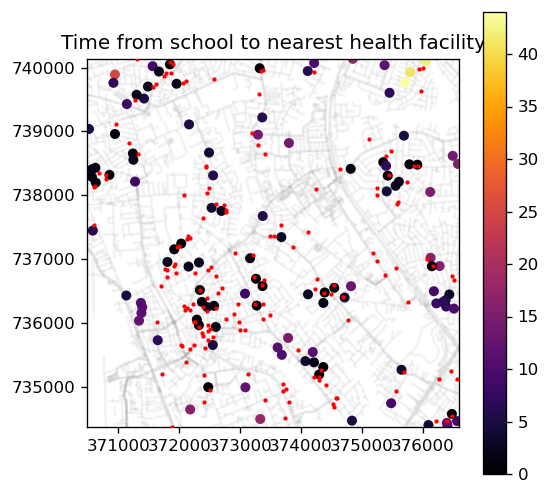

In [56]:
# Map the travel time from each school to the nearset health facility - darker dots are closer to a health facility, red dots are health facilities

# construct geodataframe
geometry = gpd.points_from_xy(nearest_df1['longitude'], nearest_df1['latitude'])
nearest_gdf = gpd.GeoDataFrame(nearest_df1, geometry=geometry, crs='EPSG:4326')

edges_plot = edges.to_crs(epsg=4326)
health_plot = health_fac.to_crs(epsg=4326)


# Plot with length column for travel time
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=120)
edges.plot(ax=ax, color='grey', alpha=.1, zorder=1)
health_fac.plot(marker='+', color='red', legend=True, ax=ax, markersize=5, zorder=3)
nearest_gdf.plot(column='length', cmap='inferno', legend=True, ax=ax, markersize=25, zorder=2)
plt.title("Time from school to nearest health facility")
ax.set_xlim(bbox_3857[0], bbox_3857[2])
ax.set_ylim(bbox_3857[1], bbox_3857[3]  )
plt.show()